In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./data/diabetes.csv')
df1 = df.copy()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.shape

(768, 9)

In [5]:
df.eq(0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

For the label 'outcome' and feature 'pregnancies' having value of 0 is normal. E.g a user can stay without being pregnant. However, for the rest(with the exception of age and diabetespedigreefunction, which both don't have 0 values), you can't have 0 values for them. E.g a person can't have a bloodpressue of 0.

This implies missing values or incomplete data, and it has to be dealt with somehow.

In [6]:
df.Glucose.min(), df.Glucose.max(), df.Glucose.median()

(np.int64(0), np.int64(199), np.float64(117.0))

In [7]:
df.Insulin.min(), df.Insulin.max(), df.Insulin.median()

(np.int64(0), np.int64(846), np.float64(30.5))

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

plotting the distribution of the features and their skewness

0 Pregnancies
1 Glucose
2 BloodPressure
3 SkinThickness
4 Insulin
5 BMI
6 DiabetesPedigreeFunction
7 Age


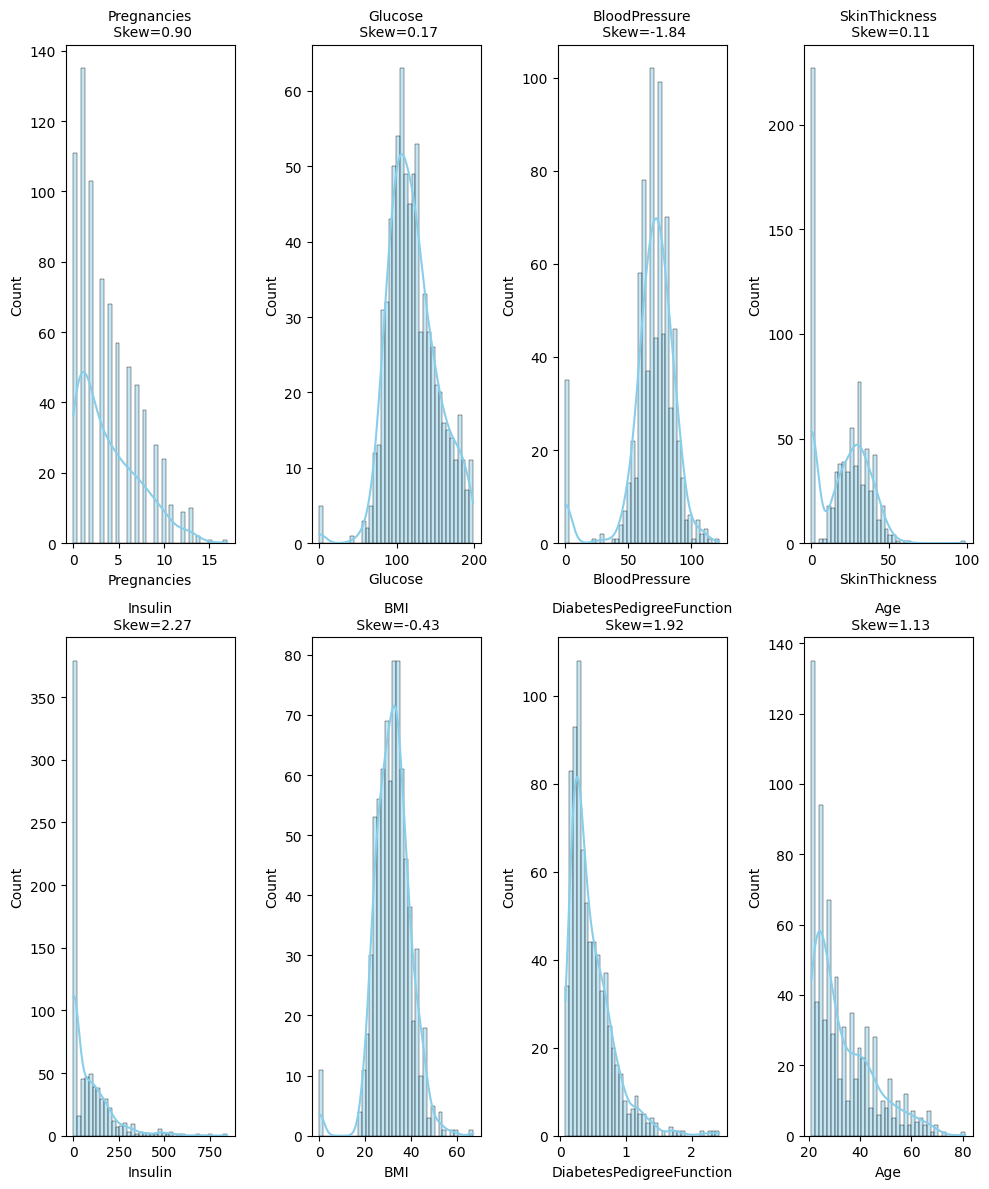

In [9]:

skewness_container = {}

col_length = int(df.columns.drop('Outcome').shape[0]/2)
fig, axes = plt.subplots(2,col_length, figsize=(10,12))
axes = axes.flatten()

for idx, col in enumerate(df.columns.drop("Outcome")):
    print(idx, col)
    ax = axes[idx]
    sns.histplot(df[col], kde=True, bins=40, color='skyblue', ax=ax)
    skewness = skew(df[col].dropna())
    skewness_container[col] = skewness
    ax.set_title(f'{col}\n Skew={skewness:.2f}', fontsize=10)
plt.tight_layout()
plt.show()

In [10]:
skewness_sum = {
    'High': [col for col,val in skewness_container.items() if abs(val) >= 1],
    'moderate': [col for col,val in skewness_container.items() if 0.5 <= abs(val) < 1 ],
    'fairly': [col for col,val in skewness_container.items() if abs(val) < 0.5],
}
skewness_sum

{'High': ['BloodPressure', 'Insulin', 'DiabetesPedigreeFunction', 'Age'],
 'moderate': ['Pregnancies'],
 'fairly': ['Glucose', 'SkinThickness', 'BMI']}

### IMPUTATION OF ZERO VALUES

From the distribution plot, 'Glucose' and 'BMI' are fairly skewed and also have low zero values; 5 and 11 respectively. So I will use median here - no distortion of distribution.

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [12]:
df_zero_values = df[['Glucose','BMI','BloodPressure']]
median_imputer = SimpleImputer(strategy='median')
df_zero_values = df_zero_values.replace(0, np.nan)
df_zero_values_imputed = pd.DataFrame(median_imputer.fit_transform(df_zero_values),
                       columns=df_zero_values.columns)

df[['Glucose', 'BMI','BloodPressure']] = df_zero_values_imputed

0 Pregnancies
1 Glucose
2 BloodPressure
3 SkinThickness
4 Insulin
5 BMI
6 DiabetesPedigreeFunction
7 Age


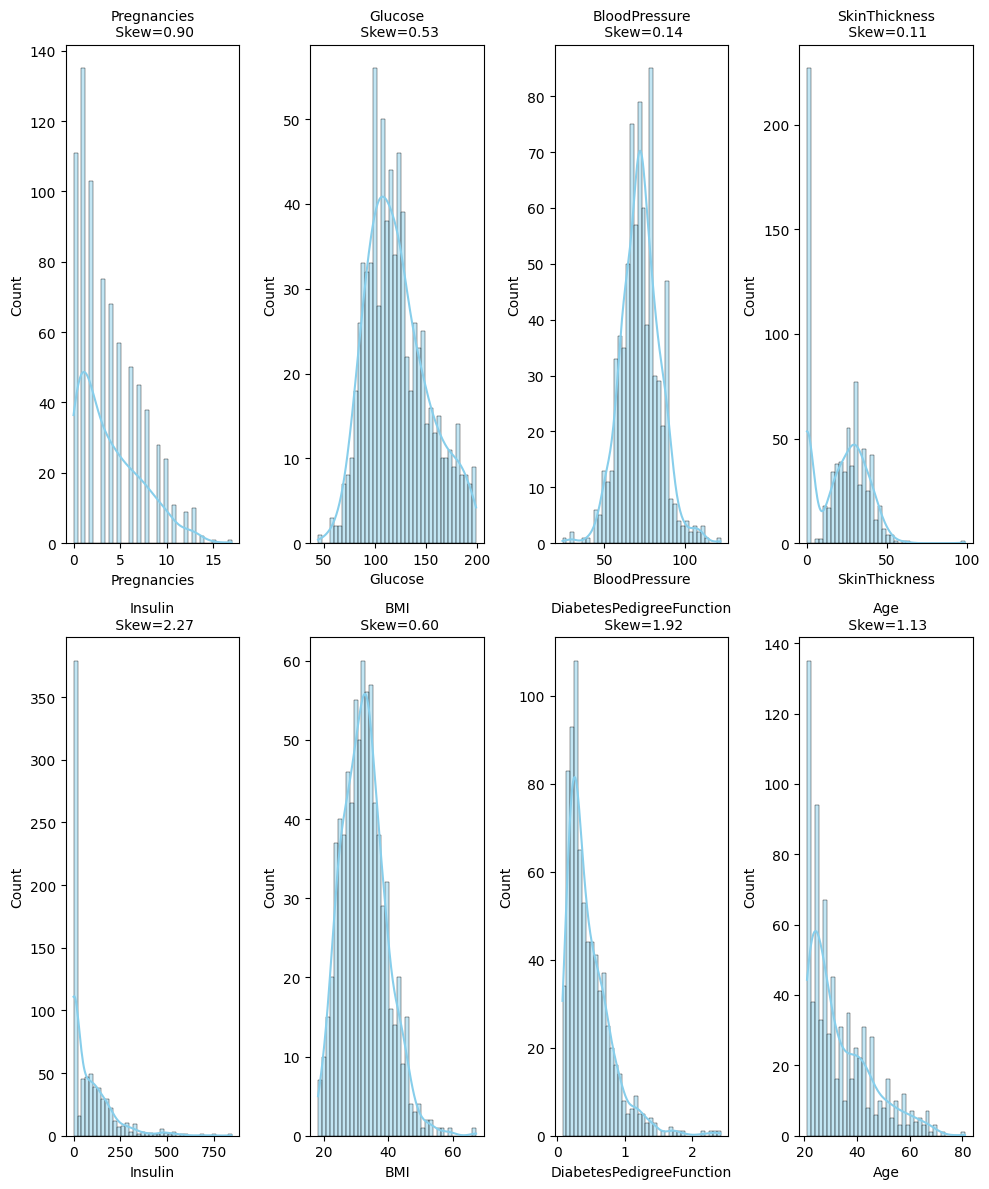

In [13]:

skewness_container = {}

col_length = int(df.columns.drop('Outcome').shape[0]/2)
fig, axes = plt.subplots(2,col_length, figsize=(10,12))
axes = axes.flatten()

for idx, col in enumerate(df.columns.drop("Outcome")):
    print(idx, col)
    ax = axes[idx]
    sns.histplot(df[col], kde=True, bins=40, color='skyblue', ax=ax)
    skewness = skew(df[col].dropna())
    skewness_container[col] = skewness
    ax.set_title(f'{col}\n Skew={skewness:.2f}', fontsize=10)
plt.tight_layout()
plt.show()

The skewness of 'Glucose' and 'BMI' looks to be worse, but it does correct the problem of left tailed skewness due to zero values.

I will include the two features in the MICE inputation and compare - this is to check if my assumption of no distortion by using mean in this context is wrong

In [14]:
df1.eq(0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [15]:
features = ['Glucose', 'BMI', 'Insulin', 'SkinThickness', 'BloodPressure']  
df1[features] = df1[features].replace(0, np.nan)



mice_inputer = IterativeImputer(max_iter=10, random_state=111)
imputed = mice_inputer.fit_transform(df1[features])

df1[features] = imputed
df1.eq(0).sum()

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

0 Pregnancies
1 Glucose
2 BloodPressure
3 SkinThickness
4 Insulin
5 BMI
6 DiabetesPedigreeFunction
7 Age


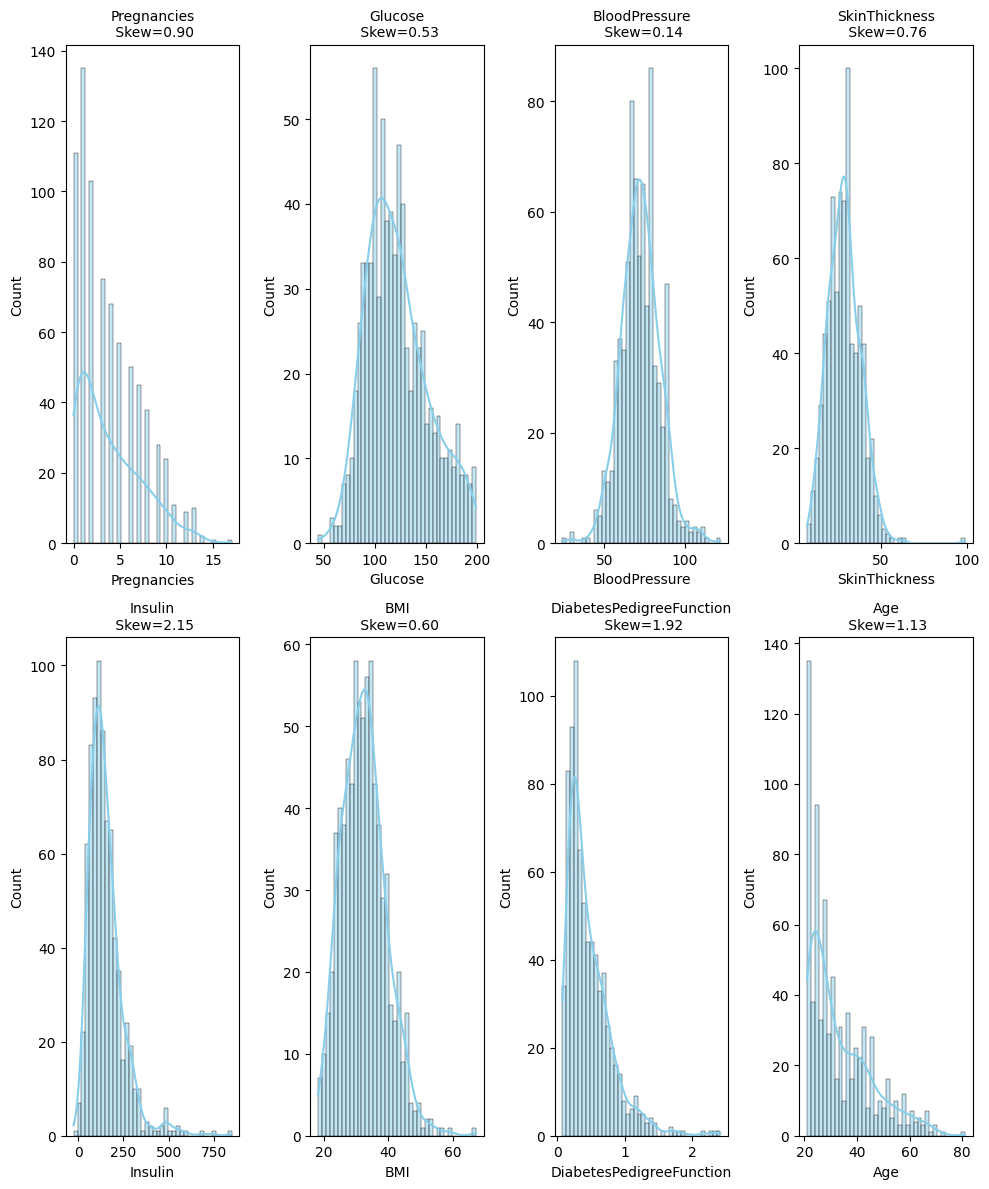

In [16]:
skewness_container = {}

col_length = int(df1.columns.drop('Outcome').shape[0]/2)
fig, axes = plt.subplots(2,col_length, figsize=(10,12))
axes = axes.flatten()

for idx, col in enumerate(df1.columns.drop("Outcome")):
    print(idx, col)
    ax = axes[idx]
    sns.histplot(df1[col], kde=True, bins=40, color='skyblue', ax=ax)
    skewness = skew(df1[col].dropna())
    skewness_container[col] = skewness
    ax.set_title(f'{col}\n Skew={skewness:.2f}', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
skewness_sum = {
    'High': [col for col,val in skewness_container.items() if abs(val) >= 1],
    'moderate': [col for col,val in skewness_container.items() if 0.5 <= abs(val) < 1 ],
    'fairly': [col for col,val in skewness_container.items() if abs(val) < 0.5],
}
skewness_sum

{'High': ['Insulin', 'DiabetesPedigreeFunction', 'Age'],
 'moderate': ['Pregnancies', 'Glucose', 'SkinThickness', 'BMI'],
 'fairly': ['BloodPressure']}

The same distribution is attained with the MICE imputation

## Next, examination of the correlation between the features

In [18]:
df_corr = df1.corr()
df_corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129652,0.209181,0.087359,0.068747,0.024477,-0.033523,0.544341,0.221898
Glucose,0.129652,1.000000,0.230087,0.242262,0.699920,0.235599,0.138322,0.268470,0.494685
BloodPressure,0.209181,0.230087,1.000000,0.241371,0.134121,0.297206,-0.000148,0.326662,0.176654
SkinThickness,0.087359,0.242262,0.241371,1.000000,0.251856,0.710747,0.124137,0.111028,0.277964
Insulin,0.068747,0.699920,0.134121,0.251856,1.000000,0.280154,0.135984,0.185666,0.360871
BMI,0.024477,0.235599,0.297206,0.710747,0.280154,1.000000,0.151454,0.030689,0.314434
DiabetesPedigreeFunction,-0.033523,0.138322,-0.000148,0.124137,0.135984,0.151454,1.000000,0.033561,0.173844
Age,0.544341,0.268470,0.326662,0.111028,0.185666,0.030689,0.033561,1.000000,0.238356
Outcome,0.221898,0.494685,0.176654,0.277964,0.360871,0.314434,0.173844,0.238356,1.000000


Using visuals, would make the relationship more obvious

C:\Users\User\AppData\Local\Temp\ipykernel_16380\3262004059.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = ax.text(j,i, round(df_corr.iloc[i][j],2), ha='center', va='center', color='w')


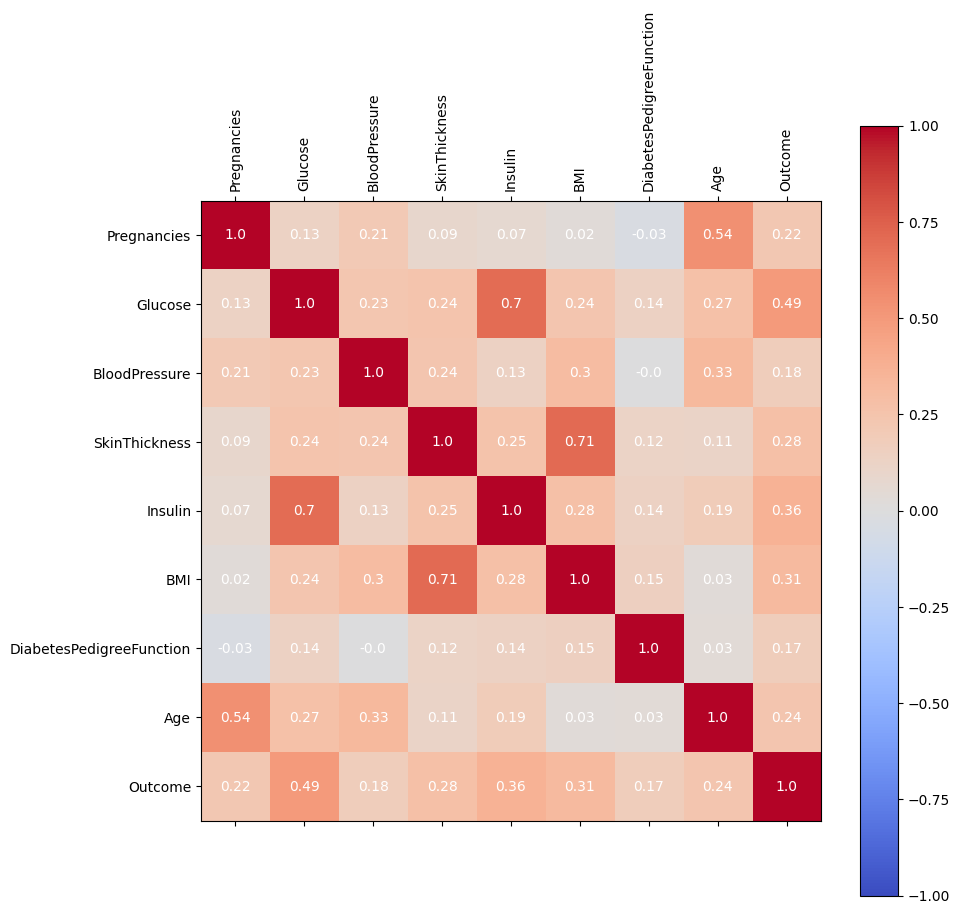

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(df_corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(df1.columns), 1)
ax.set_xticks(ticks)
ax.set_xticklabels(df1.columns)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_yticklabels(df.columns)
for i in range(df1.shape[1]):
    for j in range(9):
        text = ax.text(j,i, round(df_corr.iloc[i][j],2), ha='center', va='center', color='w')
plt.show()

In [20]:
top_5_corr = df_corr.nlargest(5, 'Outcome')
top_5_corr['Outcome']

Outcome          1.000000
Glucose          0.494685
Insulin          0.360871
BMI              0.314434
SkinThickness    0.277964
Name: Outcome, dtype: float64

Apart from Outcome, Glucose, Insulin, BMI, SkinThickness have the highest correlation with the Outcome. The rest have very little correction, so I'm using these 4 for training to establish a bases model

## Model Training

### Logistic Regression

Because of the small number of training data, I'm using fold cold-validation

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [22]:
result = []

In [23]:
x = df1[['Glucose', 'Insulin', 'BMI', 'SkinThickness']]
y = df1.iloc[:,8]

log_regress = LogisticRegression()
log_regress_score = cross_val_score(log_regress, x,y, cv=10, scoring='accuracy').mean()

result.append(log_regress_score)
log_regress_score


np.float64(0.7733937115516063)

### K-Nearest Neighbors

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
cv_scores = []
folds = 10

ks = list(range(1, int(len(x) * ((folds-1)/folds)),2))

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, x, y, cv=folds, scoring='accuracy').mean()
    cv_scores.append(score)

knn_score = max(cv_scores)

best_k = ks[cv_scores.index(knn_score)]

print('Best value for K', best_k)
result.append(knn_score)

Best value for K 37


### Support Vector Machines

In [26]:
from sklearn.svm import SVC

In [28]:
kernels = ['linear', 'rbf']

for kernel in kernels:
    svm_model = SVC(kernel = kernel)
    svm_score = cross_val_score(svm_model, x,y,cv=10,scoring='accuracy').mean()
    result.append(svm_score)

In [29]:
result

[np.float64(0.7733937115516063),
 np.float64(0.7355434039644566),
 np.float64(0.7604237867395762),
 np.float64(0.7448735475051265)]

In [30]:
model_columns = ['Log_reg', 'KNN', 'SVM_Linear', 'SVM_rbf']
df_model_scores = pd.DataFrame(result, index=model_columns)
df_model_scores

,0
Log_reg,0.773394
KNN,0.735543
SVM_Linear,0.760424
SVM_rbf,0.744874


The logistic regression model performed best. I will train the full dataset using Logistic R model

In [31]:
X = df1.drop(columns='Outcome')
y = df1['Outcome']
y.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [32]:
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline 

In [33]:
log_reg = LogisticRegression(max_iter=1000)
log_score = cross_val_score(log_reg, X,y, cv=10, scoring='accuracy').mean()
print('Logistic Regression model accuracy score: ', log_score)

Logistic Regression model accuracy score:  0.7708304853041696


In [34]:

smote = SMOTE(random_state=1111)
knn = KNeighborsClassifier(n_neighbors=17)
pipeline = Pipeline([
    ('smote', smote),
    ('knn', knn)
])
# pipeline = make_pipeline(smote, knn)
knn_score = cross_val_score(pipeline, X,y, cv=10, scoring='accuracy').mean()
knn_score

np.float64(0.6888072453861926)

Looking beyond accuracy score:

In [35]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

# Define model
log_reg = LogisticRegression(max_iter=1000)

# Define metrics you want
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Run cross-validation with multiple metrics
scores = cross_validate(log_reg, X, y, cv=5, scoring=scoring)

# Show results
for metric in scoring:
    print(f"{metric}: {scores['test_' + metric].mean():.4f}")


accuracy: 0.7722
precision: 0.7219
recall: 0.5709
f1: 0.6366
roc_auc: 0.8390


In [36]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

# Define model
log_reg_balanced = LogisticRegression(class_weight='balanced',max_iter=1000)

# Define metrics you want
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Run cross-validation with multiple metrics
scores = cross_validate(log_reg_balanced, X, y, cv=5, scoring=scoring)

# Show results
for metric in scoring:
    print(f"{metric}: {scores['test_' + metric].mean():.4f}")


accuracy: 0.7592
precision: 0.6404
recall: 0.7166
f1: 0.6761
roc_auc: 0.8382


With class balance, recall increases. I will stick with this model. I believe it is better for the model to predict a patient has diabetes as false positive (false alarm) instead of predicting false negative (patient has diabetes but model says the opposite).

In [37]:
import pickle

In [43]:
log_reg_balanced.fit(X,y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [44]:
filename = 'diabetes.sav'
with open(filename, 'wb') as f:
    pickle.dump(log_reg_balanced, f)

## Deployment

In [39]:
from flask import Flask, request, json, jsonify

In [45]:
app = Flask(__name__)

filename = 'diabetes.sav'

with open(filename, 'rb') as f:
    loaded_model = pickle.load(f)
    


test loaded model (randomly generated numbers)

In [46]:
input_data = [2, 148, 72, 35, 0, 33.6, 0.627, 50]
pred_result = loaded_model.predict([input_data])
if (pred_result[0]==1):
    print('Diabetic')
else:
    print('Non-diabetic')

pred_result_conf = loaded_model.predict_proba([input_data])
print('confidence level: ', round(np.amax(pred_result_conf[0])*100,2))


Diabetic
confidence level:  76.41


c:\Users\User\ML\Diabetes_prediction\virtenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\User\ML\Diabetes_prediction\virtenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


routes

In [47]:
@app.route('/diabetes/v1/predict', methods=['POST'])
def predict():
    features = request.json
    features_list = [features['Pregnancies'], features['Glucose'],features['BloodPressure'],
                     features['SkinThickness'], features['Insulin'], features['BMI'], features['DiabetesPedigreeFunction'],
                     features['Age'], ]
    prediction = loaded_model.predict([features_list])
    confidence = loaded_model.predict_proba([features_list])
    
    response = {}
    response['prediction'] = int(prediction[0])
    response['confidence'] = str(round(np.amax(confidence[0])*100,2))
    
    return jsonify(response)

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.165:5000
Press CTRL+C to quit
127.0.0.1 - - [15/Aug/2025 12:54:58] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [15/Aug/2025 12:55:03] "GET /favicon.ico HTTP/1.1" 404 -
192.168.0.165 - - [15/Aug/2025 12:55:10] "GET / HTTP/1.1" 404 -
192.168.0.165 - - [15/Aug/2025 12:55:15] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [15/Aug/2025 12:56:40] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [15/Aug/2025 12:57:02] "GET /diabetes/v1/predict HTTP/1.1" 405 -
c:\Users\User\ML\Diabetes_prediction\virtenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\User\ML\Diabetes_prediction\virtenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
127.0.0.1 - - [15/Aug/